In [1]:
import os, sys
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../modules')
from ar_scale import calc_ar_scale

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'

In [3]:
%%time
fname_pattern = path_to_data + 'preprocessed/ARScale_ERA5/ERA5_ARScale_*.nc'
filenames = sorted(glob.glob(fname_pattern))
## 56.5N 132.5W
lat = 56.5
lon = -132.5
df_lst = []
for i, fname in enumerate(filenames):
    print(fname)
    ds = xr.open_dataset(fname)
    ds = ds.sel(lat=lat, lon=lon)
    df = ds['IVT'].to_dataframe()
    df_lst.append(df)

df = pd.concat(df_lst)
df.to_csv('../out/IVT_ERA5_{0}N_{1}W.csv'.format(lat, lon*-1))
df

/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2000.nc


ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2001.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2002.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2003.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2004.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2005.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2006.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2007.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2008.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2009.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2010.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2011.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2012.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_2013.nc
/expanse/nfs/cw3e/cwp140/preprocessed/ARScale_ERA5/ERA5_ARScale_

,lat,lon,IVT
time,,,
2000-01-01 00:00:00,56.5,-132.5,30.500615
2000-01-01 01:00:00,56.5,-132.5,29.135459
2000-01-01 02:00:00,56.5,-132.5,27.722894
2000-01-01 03:00:00,56.5,-132.5,26.832449
2000-01-01 04:00:00,56.5,-132.5,28.031069
...,...,...,...
2023-12-31 19:00:00,56.5,-132.5,49.730049
2023-12-31 20:00:00,56.5,-132.5,57.984639
2023-12-31 21:00:00,56.5,-132.5,62.981197


In [8]:
## add water year to data as coordinate
water_year = (ar_scale.index.month >= 10) + df.index.year
df['water_year'] = water_year
df

,lat,lon,IVT,water_year
time,,,,
2000-01-01 00:00:00,59.0,-135.5,15.808814,2000
2000-01-01 01:00:00,59.0,-135.5,15.684779,2000
2000-01-01 02:00:00,59.0,-135.5,15.177232,2000
2000-01-01 03:00:00,59.0,-135.5,14.247456,2000
2000-01-01 04:00:00,59.0,-135.5,12.811141,2000
...,...,...,...,...
2023-12-31 19:00:00,59.0,-135.5,33.336114,2024
2023-12-31 20:00:00,59.0,-135.5,32.627750,2024
2023-12-31 21:00:00,59.0,-135.5,32.562283,2024


In [57]:
df.describe()

,lat,lon,IVT
count,210384.0,210384.0,210384.000000
mean,59.0,-135.5,80.489980
std,0.0,0.0,75.696367
min,59.0,-135.5,0.041244
25%,59.0,-135.5,28.932236
50%,59.0,-135.5,57.662071
75%,59.0,-135.5,106.493254
max,59.0,-135.5,786.485907


In [9]:
df = df.reset_index()
df = df.rename(columns={"time": "date"})
ar_scale = calc_ar_scale(df)
ar_scale

,start_date,end_date,duration,max_IVT,AR_scale
16,2000-10-05 11:00:00,2000-10-06 19:00:00,32.0,423.078085,1.0
38,2001-09-13 00:00:00,2001-09-14 21:00:00,45.0,507.469239,2.0
52,2002-08-07 04:00:00,2002-08-08 09:00:00,29.0,366.178009,1.0
53,2002-08-12 00:00:00,2002-08-13 08:00:00,32.0,786.485907,3.0
69,2002-10-16 06:00:00,2002-10-17 18:00:00,36.0,414.633654,1.0
...,...,...,...,...,...
658,2023-08-31 21:00:00,2023-09-01 15:00:00,18.0,547.818147,1.0
660,2023-09-09 09:00:00,2023-09-10 19:00:00,34.0,375.488884,1.0
664,2023-09-20 18:00:00,2023-09-22 03:00:00,33.0,435.319781,1.0
665,2023-10-05 11:00:00,2023-10-06 15:00:00,28.0,530.482599,2.0


In [16]:
## add month from start_date column
ar_scale = ar_scale.set_index(pd.to_datetime(ar_scale.start_date))
ar_scale

,start_date,end_date,duration,max_IVT,AR_scale
start_date,,,,,
2000-10-05 11:00:00,2000-10-05 11:00:00,2000-10-06 19:00:00,32.0,423.078085,1.0
2001-09-13 00:00:00,2001-09-13 00:00:00,2001-09-14 21:00:00,45.0,507.469239,2.0
2002-08-07 04:00:00,2002-08-07 04:00:00,2002-08-08 09:00:00,29.0,366.178009,1.0
2002-08-12 00:00:00,2002-08-12 00:00:00,2002-08-13 08:00:00,32.0,786.485907,3.0
2002-10-16 06:00:00,2002-10-16 06:00:00,2002-10-17 18:00:00,36.0,414.633654,1.0
...,...,...,...,...,...
2023-08-31 21:00:00,2023-08-31 21:00:00,2023-09-01 15:00:00,18.0,547.818147,1.0
2023-09-09 09:00:00,2023-09-09 09:00:00,2023-09-10 19:00:00,34.0,375.488884,1.0
2023-09-20 18:00:00,2023-09-20 18:00:00,2023-09-22 03:00:00,33.0,435.319781,1.0


In [18]:
## add water year to data as coordinate
water_year = (ar_scale.index.month >= 10) + ar_scale.index.year
month = ar_scale.index.month
ar_scale['water_year'] = water_year
ar_scale['month'] = month
ar_scale

,start_date,end_date,duration,max_IVT,AR_scale,water_year,month
start_date,,,,,,,
2000-10-05 11:00:00,2000-10-05 11:00:00,2000-10-06 19:00:00,32.0,423.078085,1.0,2001,10
2001-09-13 00:00:00,2001-09-13 00:00:00,2001-09-14 21:00:00,45.0,507.469239,2.0,2001,9
2002-08-07 04:00:00,2002-08-07 04:00:00,2002-08-08 09:00:00,29.0,366.178009,1.0,2002,8
2002-08-12 00:00:00,2002-08-12 00:00:00,2002-08-13 08:00:00,32.0,786.485907,3.0,2002,8
2002-10-16 06:00:00,2002-10-16 06:00:00,2002-10-17 18:00:00,36.0,414.633654,1.0,2003,10
...,...,...,...,...,...,...,...
2023-08-31 21:00:00,2023-08-31 21:00:00,2023-09-01 15:00:00,18.0,547.818147,1.0,2023,8
2023-09-09 09:00:00,2023-09-09 09:00:00,2023-09-10 19:00:00,34.0,375.488884,1.0,2023,9
2023-09-20 18:00:00,2023-09-20 18:00:00,2023-09-22 03:00:00,33.0,435.319781,1.0,2023,9


In [49]:

tmp = ar_scale.drop(['start_date', 'end_date', 'duration', 'max_IVT', 'month'], axis=1)
tmp = tmp.reset_index()
tmp = tmp.drop(['start_date'], axis=1)
tmp

,AR_scale,water_year
0,1.0,2001
1,2.0,2001
2,1.0,2002
3,3.0,2002
4,1.0,2003
...,...,...
111,1.0,2023
112,1.0,2023
113,1.0,2023
114,2.0,2024


<Axes: xlabel='water_year'>

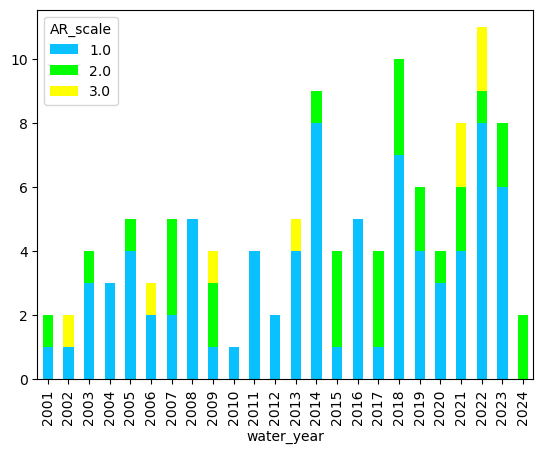

In [51]:
colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
tmp.groupby(['water_year', 'AR_scale']).size().unstack().plot(kind='bar', stacked=True, color=colors)

In [53]:

start_date='2020-11-27'
end_date='2020-12-05'
idx = (df.index >= start_date) & (df.index <= end_date)
case = df.loc[idx]
case

,lat,lon,IVT
time,,,
2020-11-27 00:00:00,59.0,-135.5,44.803837
2020-11-27 01:00:00,59.0,-135.5,48.235082
2020-11-27 02:00:00,59.0,-135.5,46.860642
2020-11-27 03:00:00,59.0,-135.5,45.855399
2020-11-27 04:00:00,59.0,-135.5,42.403127
...,...,...,...
2020-12-04 20:00:00,59.0,-135.5,189.695112
2020-12-04 21:00:00,59.0,-135.5,195.893712
2020-12-04 22:00:00,59.0,-135.5,181.768193


In [54]:
### Get x-tick and x-labels for both cases
x1 = case.index.values

x_lst = [x1]
xlbl_lst = []
xtick_lst = []
for i, x in enumerate(x_lst):
    x_lbl = []
    xtick_lst.append(x)
    for j in range(len(x)):
        t = pd.to_datetime(str(x[j]))
        x_lbl.append(t.strftime('%m-%d'))
    xlbl_lst.append(x_lbl)

In [55]:
case = case.reset_index()
case = case.rename(columns={"time": "date"})
case_arscale = calc_ar_scale(case)
case_arscale

,start_date,end_date,duration,max_IVT,AR_scale
1,2020-12-01 06:00:00,2020-12-03 05:00:00,47.0,522.499995,2


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/scratch/dnash/job_33442642/ipykernel_537835/4262880515.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('IVT $\mathrm{(kg \: m^{-1} \: s^{-1})}$', fontsize=10.)


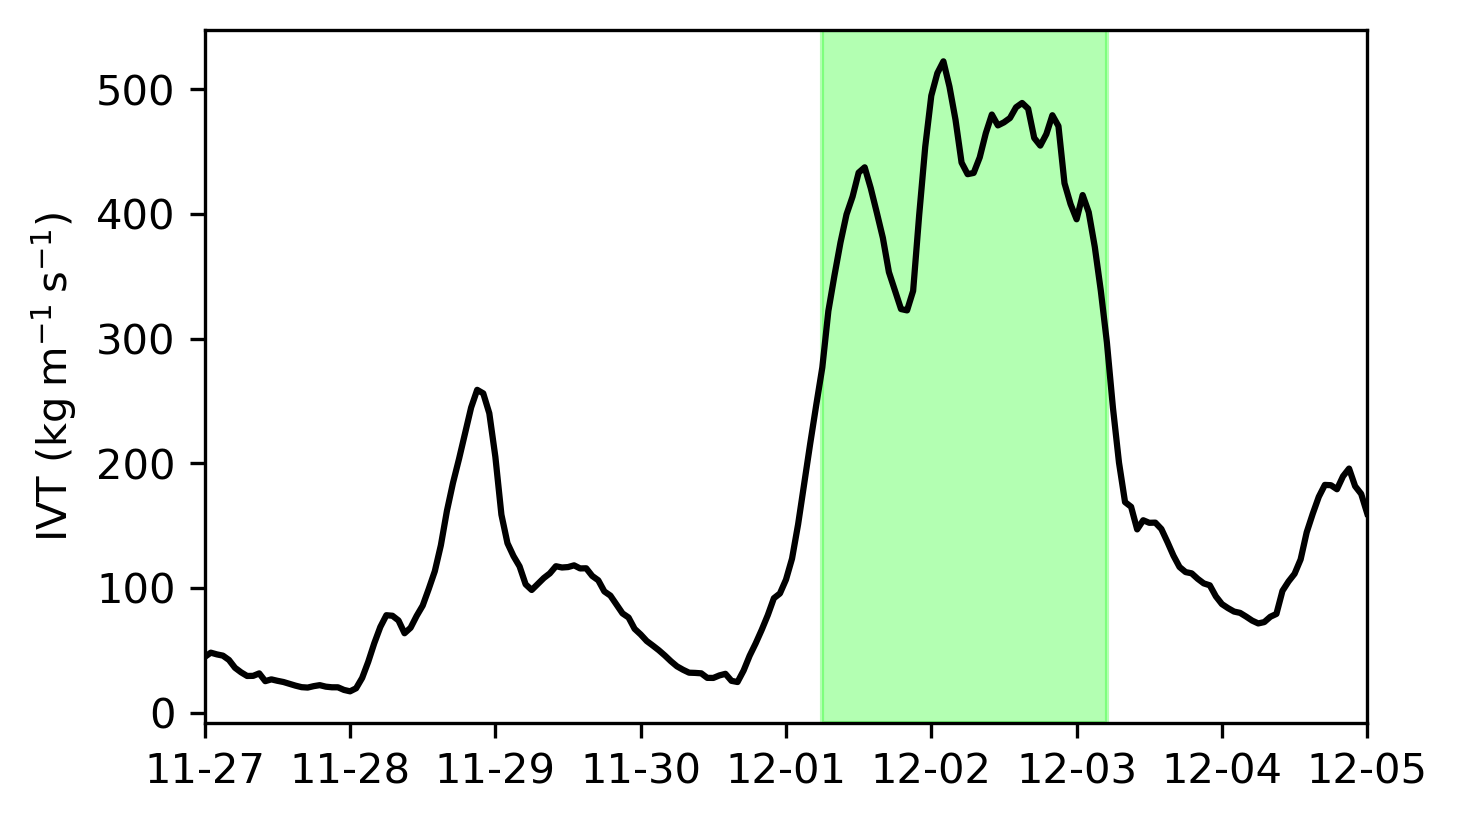

In [56]:
fname = '../figs/ar_tseries'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((5.0,3.0))
fig.dpi = 300

ax = fig.add_subplot(1, 1, 1)
ax.plot(x1, case.IVT.values, color='k')
ax.set_ylabel('IVT $\mathrm{(kg \: m^{-1} \: s^{-1})}$', fontsize=10.)
ax.set_xlim(x1.min(), x1[-24])

## x-axis format dates/ticks
x_ticks = xtick_lst[0]
x_labels = xlbl_lst[0]
ax.set_xticks(x_ticks[::24]) # set the labels every x hours
ax.set_xticklabels(x_labels[::24], fontsize=10)

# highlight a time range
for index, row in case_arscale.iterrows():
    if row['AR_scale'] == 1:
        c = (10./255.0, 193./255.0, 255./255.0) #10, 193, 255
    elif row['AR_scale'] == 2:
        c = (4./255.0, 255./255.0, 3./255.0) #4, 255, 3
    elif row['AR_scale'] == 3:
        c = (255./255.0, 255./255.0, 3./255.0) #255, 255, 3
    elif row['AR_scale'] == 4:
        c = (255./255.0, 166./255.0, 2./255.0) #255, 166, 2
    elif row['AR_scale'] == 5:
        c = (255./255.0, 1./255.0, 0./255.0) #255, 1, 0
        

    ax.axvspan(row['start_date'], row['end_date'], color=c, alpha=0.3)
    
# ## add twin axis for SWE
# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.bar(x1[::24], SWE, color='tab:blue', alpha=0.5, zorder=0)
# ax2.set_ylabel('SWE (inches)', fontsize=10., color='tab:blue')    
    
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()